# Seminário prático - Experimentos sobre meta-aprendizado

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score, f1_score, classification_report, plot_confusion_matrix
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
from sklearn.datasets import load_iris
from aux import preprocess_default, ALL_ACC, ALL_ACC_SET, drop_draw_set_class
from itertools import combinations
from sklearn.model_selection import StratifiedKFold

In [17]:
data = pd.read_csv("meta-base.csv")
data

,general.attrToInst,general.catToNum,general.freqClass.mean,general.freqClass.sd,general.instToAttr,general.nrAttr,general.nrBin,general.nrCat,general.nrClass,general.nrInst,...,C4.5.auc,kNN.acc,kNN.f1m,kNN.auc,SVM.acc,SVM.f1m,SVM.auc,RF.acc,RF.f1m,RF.auc
0,0.100000,0.000000,0.5,0.471405,10.000000,60,0,0,2,600,...,0.993992,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.042056,0.000000,0.5,0.204863,23.777778,9,0,0,2,214,...,0.786753,0.789214,0.764841,0.879050,0.770022,0.733372,0.835946,0.848485,0.822825,0.916196
2,0.121622,5.000000,0.5,0.066888,8.222222,18,9,15,2,148,...,0.813973,0.807071,0.803779,0.887428,0.846863,0.843160,0.927110,0.866887,0.861265,0.941109
3,0.492063,0.148148,0.5,0.145911,2.032258,31,0,4,2,63,...,0.662129,0.663429,0.680036,0.749489,0.761619,0.750802,0.827020,0.785238,0.771251,0.833724
4,0.020833,0.000000,0.5,0.105224,48.000000,7,2,0,2,336,...,0.959853,0.942531,0.941450,0.977326,0.966627,0.965831,0.985190,0.965199,0.964476,0.987683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.223881,0.071429,0.5,0.158307,4.466667,15,1,1,2,67,...,0.779784,0.768214,0.757795,0.843975,0.697202,0.701777,0.808815,0.798333,0.784645,0.858558
396,0.003472,0.000000,0.5,0.283170,288.000000,6,0,6,2,1728,...,0.982767,0.877835,0.844500,0.955360,0.957931,0.950636,0.993741,0.989701,0.987869,0.999346
397,0.021277,0.000000,0.5,0.342688,47.000000,18,0,0,2,846,...,0.969553,0.970795,0.962234,0.993139,0.979193,0.972641,0.996332,0.986998,0.982835,0.998817
398,0.023500,0.000000,0.5,0.565685,42.553191,47,0,0,2,2000,...,0.981546,0.993950,0.983220,0.998558,0.994550,0.984556,0.999174,0.988250,0.965376,0.998578


# Primeiro experimento - 5 Classes

In [18]:
#remove as colunas referentes às medidas f1m e auc
data.drop(data.filter(regex='(.*?\.auc|.*?\.f1m)').columns, axis=1, inplace=True)
data.loc[:, ['landmarking.randomNode.sd', 'landmarking.worstNode.mean', 'landmarking.worstNode.sd', 'ANN.acc', 
             'C4.5.acc', 'kNN.acc', 'SVM.acc', 'RF.acc']]

,landmarking.randomNode.sd,landmarking.worstNode.mean,landmarking.worstNode.sd,ANN.acc,C4.5.acc,kNN.acc,SVM.acc,RF.acc
0,0.038789,0.886667,0.041425,1.000000,0.992000,1.000000,1.000000,1.000000
1,0.089963,0.617662,0.076761,0.708379,0.784846,0.789214,0.770022,0.848485
2,0.123754,0.560536,0.119251,0.837292,0.792357,0.807071,0.846863,0.866887
3,0.160420,0.639048,0.171734,0.767238,0.646000,0.663429,0.761619,0.785238
4,0.110580,0.604069,0.075009,0.961919,0.949307,0.942531,0.966627,0.965199
...,...,...,...,...,...,...,...,...
395,0.160472,0.636310,0.179899,0.770893,0.765179,0.768214,0.697202,0.798333
396,0.018734,0.700249,0.018734,0.999768,0.950167,0.877835,0.957931,0.989701
397,0.041359,0.742169,0.042820,0.982605,0.962633,0.970795,0.979193,0.986998
398,0.008433,0.900000,0.000000,0.994850,0.983450,0.993950,0.994550,0.988250


In [19]:
#remove as amostras com empate (com relação à maior acurácia) e determina as classes
data = drop_draw_set_class(data)
data.loc[:, ['landmarking.randomNode.mean', 'landmarking.randomNode.sd', 'landmarking.worstNode.mean', 'landmarking.worstNode.sd', 'Class']]

,landmarking.randomNode.mean,landmarking.randomNode.sd,landmarking.worstNode.mean,landmarking.worstNode.sd,Class
0,0.655297,0.089963,0.617662,0.076761,RF.acc
1,0.593000,0.123754,0.560536,0.119251,RF.acc
2,0.569762,0.160420,0.639048,0.171734,RF.acc
3,0.674139,0.110580,0.604069,0.075009,SVM.acc
4,0.648228,0.142807,0.643772,0.147598,ANN.acc
...,...,...,...,...,...
378,0.676190,0.160472,0.636310,0.179899,RF.acc
379,0.700249,0.018734,0.700249,0.018734,ANN.acc
380,0.752254,0.041359,0.742169,0.042820,RF.acc
381,0.903000,0.008433,0.900000,0.000000,ANN.acc


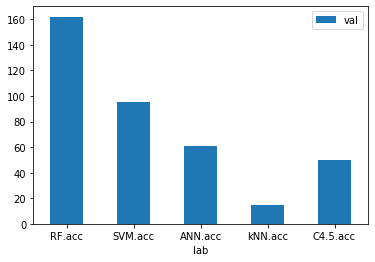

In [20]:
#plota distribuição das classes
X = data.drop('Class', axis=1)
y = data['Class']

vec = list(zip( *[*Counter( y ).items()])) 
gambs = pd.DataFrame(dict(zip(['lab', 'val'],vec))) 
ax = gambs.plot.bar(x='lab', y='val', rot=0) 
plt.show(block=True)

Fold  1
Accuracy: 0.4358974358974359 

Confusion matrix


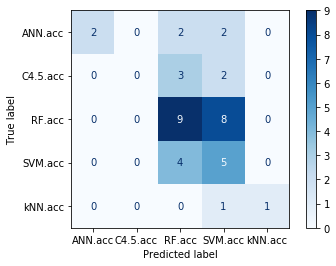


 

Fold  2
Accuracy: 0.3333333333333333 

Confusion matrix


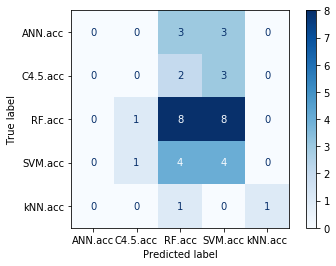


 

Fold  3
Accuracy: 0.46153846153846156 

Confusion matrix


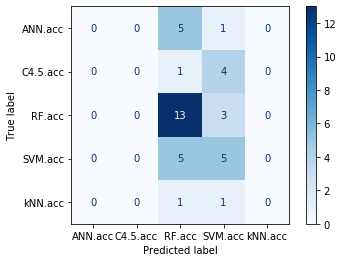


 

Fold  4
Accuracy: 0.3157894736842105 

Confusion matrix


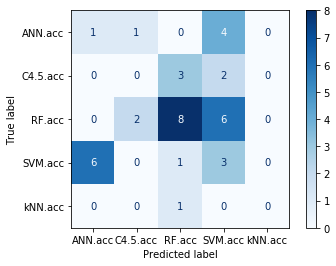


 

Fold  5
Accuracy: 0.42105263157894735 

Confusion matrix


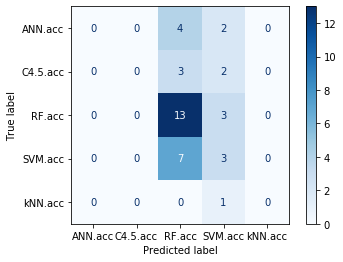


 

Fold  6
Accuracy: 0.39473684210526316 

Confusion matrix


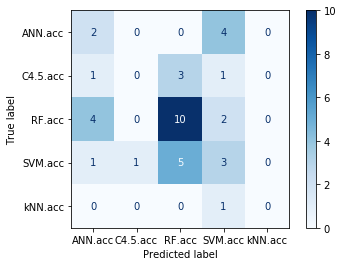


 

Fold  7
Accuracy: 0.5789473684210527 

Confusion matrix


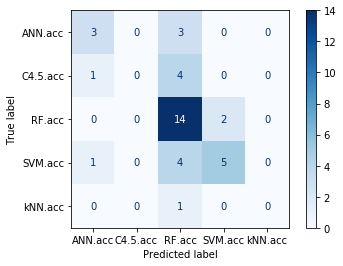


 

Fold  8
Accuracy: 0.4473684210526316 

Confusion matrix


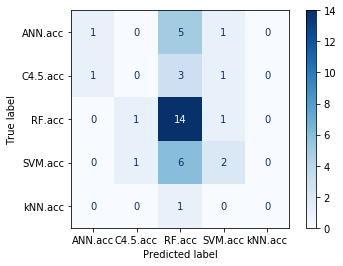


 

Fold  9
Accuracy: 0.4473684210526316 

Confusion matrix


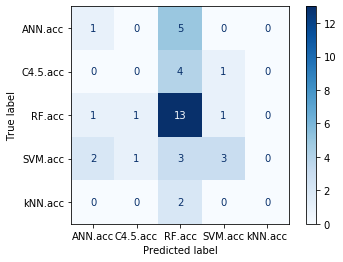


 

Fold  10
Accuracy: 0.4473684210526316 

Confusion matrix


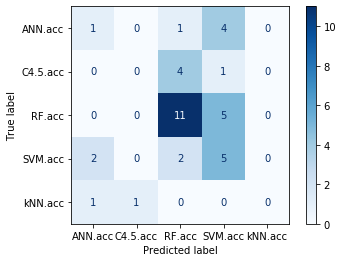


 

------------------------
Considered classes : All 

Mean accuracy =  0.4283400809716599 



In [31]:
rfc = RandomForestClassifier(n_estimators=200)
k = 0
acc = 0
acc_sum = 0   
n_splits = 10

skf = StratifiedKFold(n_splits=n_splits)
for train_index, test_index in skf.split(X, y):
      k += 1  
      print("Fold ", k)
      rfc.fit(X.loc[train_index, :], y.loc[train_index])
      y_pred = rfc.predict(X.loc[test_index, :], )

      #avaliação da predição

      #acurácia
      acc = accuracy_score(y_true=y.loc[test_index], y_pred=y_pred)
      acc_sum += acc
      print(f"Accuracy: {acc} \n")

      #matriz de confusão
      print("Confusion matrix")  
      disp = plot_confusion_matrix(rfc, X.loc[test_index, :], y.loc[test_index],
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
      plt.show()
      print("\n \n")

      


#printa as médias das medidas tiradas nos 10 folds
print("------------------------")
print("Considered classes : All \n")
print("Mean accuracy = ", acc_sum / n_splits, "\n")

# Segundo experimento - Classes dois a dois

Considered classes :  {'SVM.acc', 'RF.acc'} 

Fold  1
Accuracy: 0.45864661654135336 



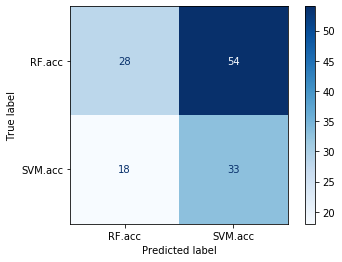


 

Fold  2
Accuracy: 0.6742424242424242 



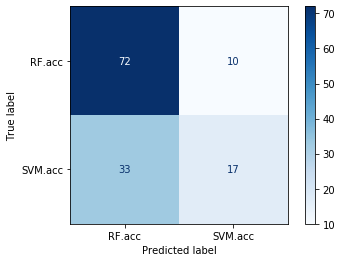


 

Fold  3
Accuracy: 0.696969696969697 



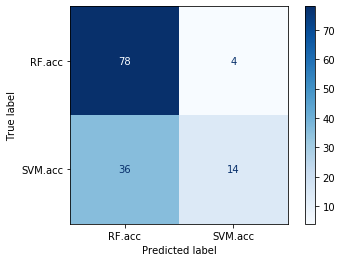


 

Mean accuracy =  0.6099529125844915 

-----------------------

Considered classes :  {'RF.acc', 'C4.5.acc'} 

Fold  1
Accuracy: 0.7633587786259542 



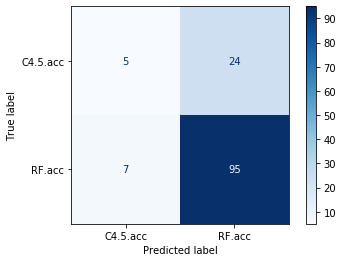


 

Fold  2
Accuracy: 0.7709923664122137 



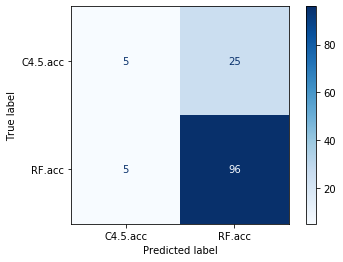


 

Fold  3
Accuracy: 0.8091603053435115 



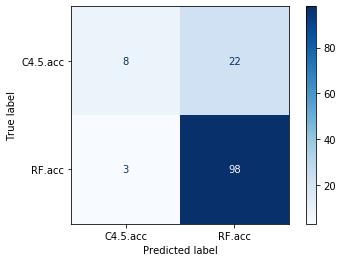


 

Mean accuracy =  0.7811704834605598 

-----------------------

Considered classes :  {'SVM.acc', 'C4.5.acc'} 

Fold  1
Accuracy: 0.6287878787878788 



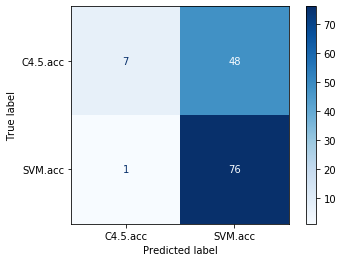


 

Fold  2
Accuracy: 0.7045454545454546 



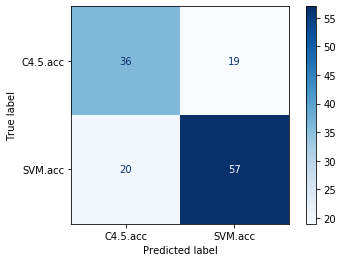


 

Fold  3
Accuracy: 0.6030534351145038 



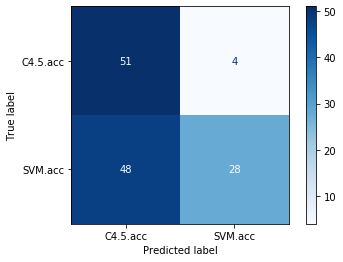


 

Mean accuracy =  0.6454622561492791 

-----------------------

Considered classes :  {'kNN.acc', 'RF.acc'} 

Fold  1
Accuracy: 0.8636363636363636 



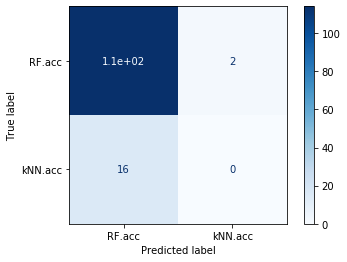


 

Fold  2
Accuracy: 0.8712121212121212 



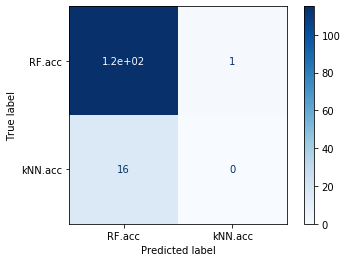


 

Fold  3
Accuracy: 0.8787878787878788 



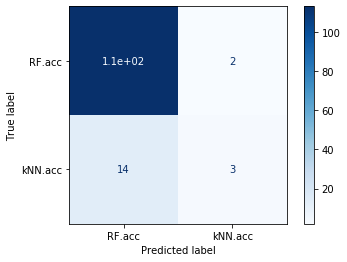


 

Mean accuracy =  0.8712121212121212 

-----------------------

Considered classes :  {'kNN.acc', 'SVM.acc'} 

Fold  1
Accuracy: 0.7954545454545454 



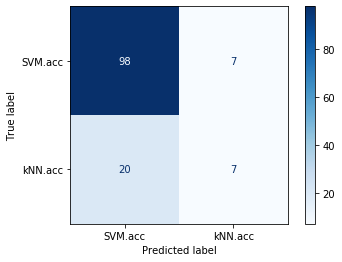


 

Fold  2
Accuracy: 0.8333333333333334 



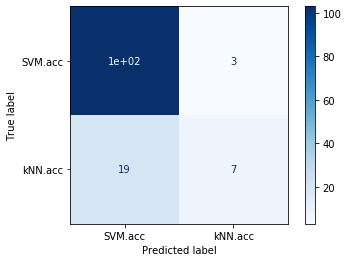


 

Fold  3
Accuracy: 0.8181818181818182 



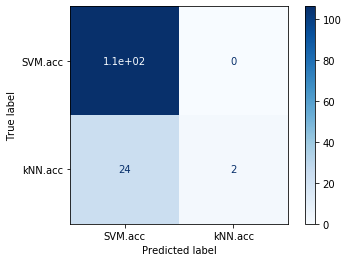


 

Mean accuracy =  0.8156565656565657 

-----------------------

Considered classes :  {'kNN.acc', 'C4.5.acc'} 

Fold  1
Accuracy: 0.6992481203007519 



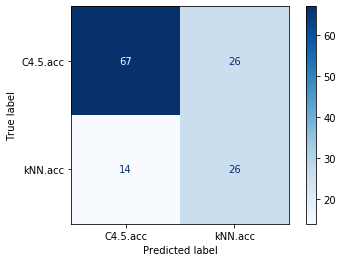


 

Fold  2
Accuracy: 0.7575757575757576 



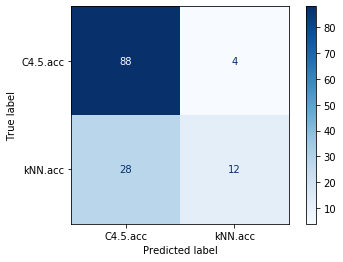


 

Fold  3
Accuracy: 0.7348484848484849 



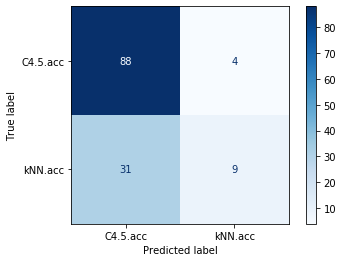


 

Mean accuracy =  0.7305574542416648 

-----------------------

Considered classes :  {'ANN.acc', 'RF.acc'} 

Fold  1
Accuracy: 0.7076923076923077 



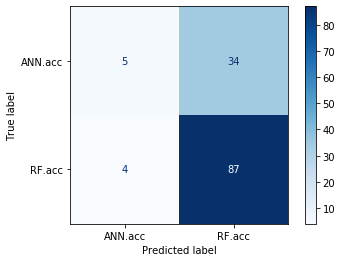


 

Fold  2
Accuracy: 0.7 



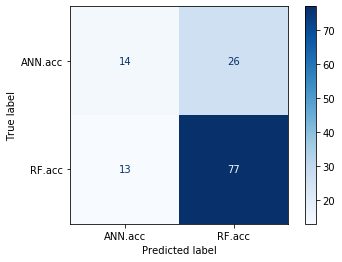


 

Fold  3
Accuracy: 0.7364341085271318 



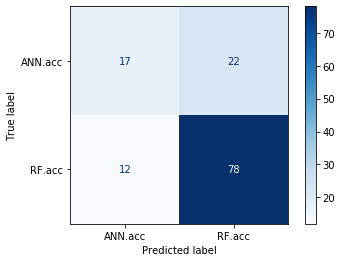


 

Mean accuracy =  0.7147088054064797 

-----------------------

Considered classes :  {'ANN.acc', 'SVM.acc'} 

Fold  1
Accuracy: 0.5984848484848485 



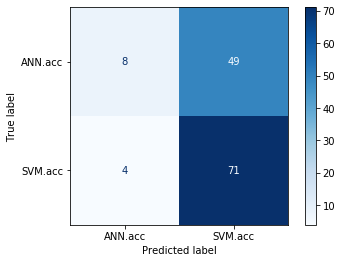


 

Fold  2
Accuracy: 0.6136363636363636 



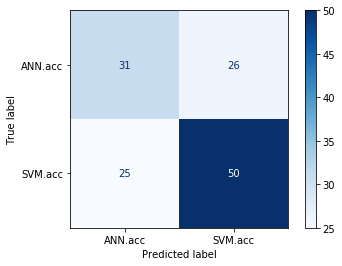


 

Fold  3
Accuracy: 0.48854961832061067 



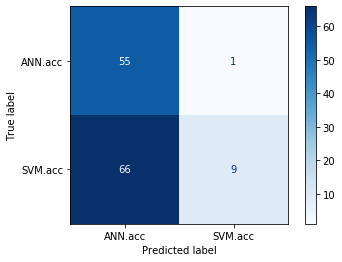


 

Mean accuracy =  0.5668902768139409 

-----------------------

Considered classes :  {'ANN.acc', 'C4.5.acc'} 

Fold  1
Accuracy: 0.6641221374045801 



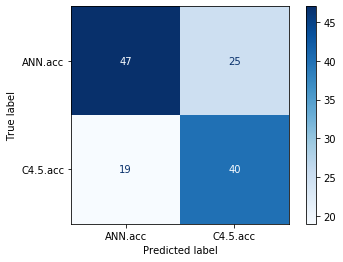


 

Fold  2
Accuracy: 0.6946564885496184 



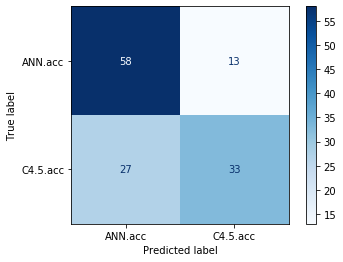


 

Fold  3
Accuracy: 0.7153846153846154 



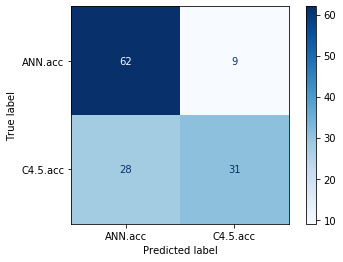


 

Mean accuracy =  0.6913877471129379 

-----------------------

Considered classes :  {'kNN.acc', 'ANN.acc'} 

Fold  1
Accuracy: 0.5606060606060606 



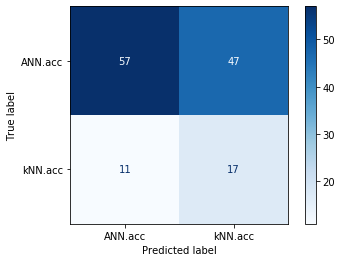


 

Fold  2
Accuracy: 0.8106060606060606 



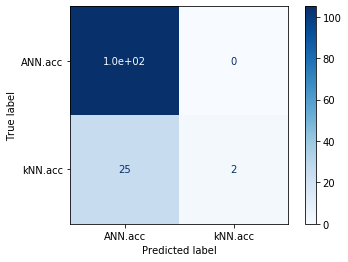


 

Fold  3
Accuracy: 0.7938931297709924 



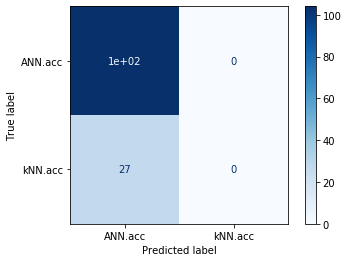


 

Mean accuracy =  0.7217017503277044 

-----------------------



In [35]:
comb_to_drop = list(combinations(ALL_ACC, r=3))
raw = pd.read_csv('meta-base.csv')

classifiers_list = []
acc_mean_list = []

#para cada combinação de 3 colunas, dropa essas 3 deixando 2 colunas para o problema de classificação
#faz o pre_processamento do dataframe passando as colunas consideradas (retira os empates e seta as classes)
#divide o data em features e rótulo e divide os folds
for to_drop in comb_to_drop:
    data = raw.drop(list(to_drop), axis=1)
    considered_classes = ALL_ACC_SET - set(to_drop)
    data = preprocess_default(data, list(considered_classes))
    rfc = RandomForestClassifier(n_estimators=200)
    X = data.drop('Class', axis=1)
    y = data['Class']
    k = 0
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits)
    acc = 0
    acc_sum = 0
    classifiers_list.append([])
    print("Considered classes : ", considered_classes, "\n")
    for train_index, test_index in skf.split(X, y):
        k += 1
        print("Fold ", k)
        rfc.fit(X.loc[train_index, :], y.loc[train_index])
        y_pred = rfc.predict(X.loc[test_index, :], )

        #avaliação da predição

        #acurácia
        acc = accuracy_score(y_true=y.loc[test_index], y_pred=y_pred)
        acc_sum += acc
        print(f"Accuracy: {acc} \n")

        #matriz de confusão
        disp = plot_confusion_matrix(rfc, X.loc[test_index, :], y.loc[test_index],
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
        plt.show()
        print("\n \n")

        classifiers_list[-1].append(rfc)

        
    
    print("Mean accuracy = ", acc_sum / n_splits, "\n")
    acc_mean_list.append(acc_sum / n_splits)
    print("-----------------------\n")
 
    